## ML - Logistic Regression 

The following dataset is used to classify the car acceptability into classes: 
unacceptable, acceptable, good and very good.

Import the car.data dataset from https://archive.ics.uci.edu/ml/machine-learning-databases/car/

1. Extract X as all columns except the last column and Y as last column.
2. Visualize the dataset using any two appropriate graphs.
3. Visualize the correlation between all the variables of dataset. 
4. Split the data into training set and testing set.Perform 10-fold cross validation
5. Train a Logistic regression model for the dataset.
6. Can we compute the accuracy and confusion matrix.
7. Predict and display the class label of a car with following attributes : 
> buying, main, doors, persons, lug_boot, safety -->
[vhigh,low,4,more,small,med].


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set()

# Plotly libraries
import plotly
import plotly.express as px
import plotly.graph_objs as go
import chart_studio.plotly as py
import os
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode, plot
cf.go_offline()

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

In [ ]:
car_data = pd.read_csv('car_data.csv')
car_data.head()

## Performing EDA on the given dataset

In [4]:
car_data.columns = car_data.columns.str.title()  # Formatting the column names

In [ ]:
car_data[['Buying','Maint','Doors','Persons','Lug_Boot','Safety', 'Target']].describe().transpose()

In [ ]:
car_data.info()

##### dropping duplicate values

In [7]:
car_data.drop_duplicates(keep=False,inplace=True)

In [ ]:
car_data.info()

### Plotting BAR charts for each feature

In [ ]:
car_data.Target.value_counts().plot(kind='bar', title='Count (target)')

#### Target data is higly imbalanced.
acc - 22%

good - 3.9%

unacc - 70%

vgood - 3.7%

This will result in overfitting. The model will be biased towards the "unacc" class.

In [ ]:
sns.set(style='white')
car_data['Buying'].str.strip("'").value_counts()[0:5].iplot(kind='bar',title='Buying Plot',fontsize=14,color='blue')

In [ ]:
sns.set(style='white')
car_data['Maint'].str.strip("'").value_counts()[0:5].iplot(kind='bar',title='Maintainence Plot',fontsize=14,color='#9370DB')

In [ ]:
sns.set(style='white')
car_data['Doors'].str.strip("'").value_counts()[0:5].iplot(kind='bar',title='Doors Plot',fontsize=14,color='purple')

In [ ]:
sns.set(style='white')
car_data['Persons'].str.strip("'").value_counts()[0:5].iplot(kind='bar',title='Capacity of Persons',fontsize=14,color='green')

In [ ]:
sns.set(style='white')
car_data['Lug_Boot'].str.strip("'").value_counts()[0:5].iplot(kind='bar',title='Luggage/Boot Space',fontsize=14,color='yellow')

In [ ]:
sns.set(style='white')
car_data['Safety'].str.strip("'").value_counts()[0:5].iplot(kind='bar',title='Safety Rating',fontsize=14,color='orange')

In [ ]:
sns.set(style='white')
car_data['Target'].str.strip("'").value_counts()[0:5].iplot(kind='bar',title='Overall Rating',fontsize=14,color='pink')

##### We can clearly see that the Target label distribution is biased towards "unacc" class which can lead the model to predict most test cases as "unacc". This is a major concern in ML models, which can be addressed with over-sampling or under-sampling techniques.

### Check for Missing values

In [36]:
# getting the sum of null values and ordering.
total = car_data.isnull().sum().sort_values(ascending = False)  

#getting the percent and order of null.
percent = (car_data.isnull().sum()/car_data.isnull().count()*100).sort_values(ascending =False)

# Concatenating the total and percent
df = pd.concat([total , percent],axis =1,keys=['Total' ,'Percent'])

# Returning values of nulls different of 0
print(df[~(df['Total'] == 0)])

print()
print("No missing values present")

Empty DataFrame
Columns: [Total, Percent]
Index: []

No missing values present


In [37]:
from collections import defaultdict

#### using Label-Encoder to convert data into numerical

In [ ]:
labelencoder = LabelEncoder()

encoder_dict = defaultdict(LabelEncoder)
labeled_df = car_data.apply(lambda x: encoder_dict[x.name].fit_transform(x))
# train_enc = train.apply(labelencoder.fit_transform)
labeled_df.head()

In [ ]:
labeled_df.info()

In [40]:
data_training_vars = labeled_df.columns.values.tolist()
y_vars = ['Target']
x_vars = [i for i in data_training_vars if i not in y_vars]

X = labeled_df[x_vars]
y = labeled_df[y_vars]

In [ ]:
X.head(), y.head()

In [42]:
#labels_decoded = y.apply(lambda x: encoder_dict[x.name].inverse_transform(x))
labels = list(range(0,4))
target_labels = [encoder_dict['Target'].inverse_transform([names]).tolist()[0] for names in labels]
print(target_labels)

['acc', 'good', 'unacc', 'vgood']


#### Using Select-K Best to find the correlation between our given features 

In [24]:
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  # print best features

      Specs       Score
3   Persons  178.041521
5    Safety   72.963169
4  Lug_Boot   34.263782
1     Maint   10.307863
2     Doors    6.893969
0    Buying    6.547420


In [25]:
scaler = MinMaxScaler() # StandardScaler
X_scaled = scaler.fit_transform(X)

In [26]:
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X_scaled,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  # print 10 best features

      Specs      Score
3   Persons  89.020760
5    Safety  36.481585
4  Lug_Boot  17.131891
1     Maint   3.435954
2     Doors   2.297990
0    Buying   2.182473


### Splitting the given data into TRAIN / TEST sets

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=0, test_size=0.5)

### Building a Pipeline to fit our model along with K-Fold cross validation of 10 folds

#### GridSearchCV lets us combine an estimator with a grid search preamble to tune hyper-parameters. The method picks the optimal parameter from the grid search and uses it with the estimator selected by the user. GridSearchCV inherits the methods from the classifier, so we can use the score, predict, etc., methods directly through the GridSearchCV interface. This technique is used to find the optimal parameters to use with an algorithm. 

In [ ]:
# Create first pipeline for base without reducing features.
pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier' , LogisticRegression())])

# Create param grid.
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2', 'none'], 
    'classifier__C' : np.logspace(-4, 3, 10),
    'classifier__solver' : ['lbfgs', 'newton-cg'],  # , ''
    'classifier__multi_class' : ['ovr', 'auto', 'multinomial']
    },
#     {'classifier' : [RandomForestClassifier()],
#     'classifier__n_estimators' : list(range(10,100,20)),
#     'classifier__max_features' : list(range(6,30,5)) }
]

print(f"# Tuning hyper-parameters ")
best_clf = GridSearchCV(pipe, param_grid = param_grid, cv=10, verbose=1, refit=True, n_jobs=-1, scoring='accuracy')

best_clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(best_clf.best_params_)
print()

print("Detailed classification report:")
print()
y_true, y_pred = y_test, best_clf.predict(X_test)
print(classification_report(y_true, y_pred, target_names=target_labels))
print()
# print(f'Accuracy of logistic Regression classifier on test set: {best_clf.score(X_test, y_test)}')

###### Best parameters set found on development set:

{'classifier': LogisticRegression(C=0.07196856730011514, multi_class='ovr', solver='newton-cg'), 'classifier__C': 0.07196856730011514, 'classifier__multi_class': 'ovr', 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}

In [45]:
print(f'Accuracy of Logistic Regression classifier on test set: {accuracy_score(y_true, y_pred)}')

Accuracy of Logistic Regression classifier on test set: 0.6921296296296297


In [ ]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_clf, X_test, y_test,
                                 display_labels=target_labels,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

#### given Test set : [vhigh,low,4,more,small,med]

In [31]:
test_data = {'Buying':['vhigh'], 
             'Maint':['low'],
             'Doors':['4'],
             'Persons':['more'],
             'Lug_Boot':['small'],
             'Safety':['med'] }
    
test_y = pd.DataFrame.from_dict(test_data, )

In [32]:
test_df = test_y.apply(lambda x: encoder_dict[x.name].fit_transform(x))

In [33]:
y1 = best_clf.predict(test_df)

In [34]:
score = best_clf.predict_proba(test_df)

In [35]:
y1.tolist()[0], score.tolist()[0][y1.tolist()[0]]

(2, 0.7264092885862573)

In [36]:
test_label = encoder_dict['Target'].inverse_transform(y1)

In [37]:
import json

print(f"given Test_data : \n\n{json.dumps(test_data, indent=4)}")
print()
print(f" Predicted_Class : '{test_label.tolist()[0]}', Accuracy : {round(score.tolist()[0][y1.tolist()[0]]*100, 2)}%")

given Test_data : 

{
    "Buying": [
        "vhigh"
    ],
    "Maint": [
        "low"
    ],
    "Doors": [
        "4"
    ],
    "Persons": [
        "more"
    ],
    "Lug_Boot": [
        "small"
    ],
    "Safety": [
        "med"
    ]
}
 Predicted_Class : 'unacc', Accuracy : 72.64%


In [47]:
def plot_decision_boundaries(X, y, model_class, **model_params):
    """
    Function to plot the decision boundaries of a classification model.
    This uses just the first two columns of the data for fitting 
    the model as we need to find the predicted value for every point in 
    scatter plot.
    Arguments:
            X: Feature data as a NumPy-type array.
            y: Label data as a NumPy-type array.
            model_class: A Scikit-learn ML estimator class 
            e.g. GaussianNB (imported from sklearn.naive_bayes) or
            LogisticRegression (imported from sklearn.linear_model)
            **model_params: Model parameters to be passed on to the ML estimator
    
    Typical code example:
            plt.figure()
            plt.title("KNN decision boundary with neighbros: 5",fontsize=16)
            plot_decision_boundaries(X_train,y_train,KNeighborsClassifier,n_neighbors=5)
            plt.show()
    """
    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")
    # Reduces to the first two columns of data
    reduced_data = X[:, :2]
    # Instantiate the model object
    model = model_class(**model_params)
    # Fits the model with the reduced data
    model.fit(reduced_data, y)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)
    plt.xlabel("Feature-1",fontsize=15)
    plt.ylabel("Feature-2",fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    return plt

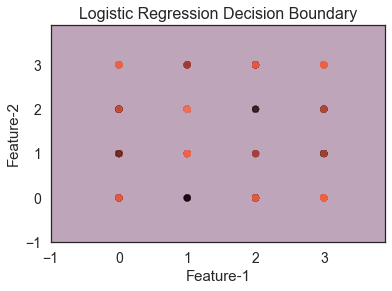

In [48]:
plt.figure()
plt.title("Logistic Regression Decision Boundary", fontsize=16)
plot_decision_boundaries(X_train, y_train, LogisticRegression)
plt.show()

### Potting the ROC-AUC curves

In [49]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)

print(X.shape, y.shape)
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

(1728, 6) (1728, 4)


One-vs-Rest ROC AUC scores:
0.786079 (macro),
0.781327 (weighted by prevalence)


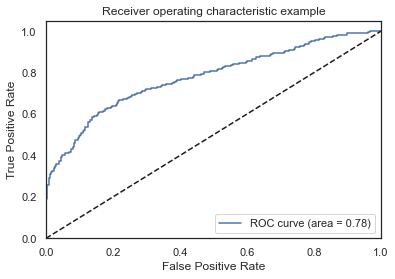

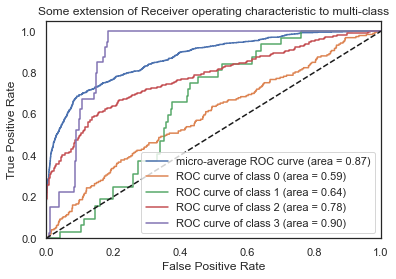

In [50]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
for i in range(n_classes):
    fpr[i], tpr[i], thers = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


y_prob = best_clf.predict_proba(X_test)

macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")

print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()